In [1]:
# token replacement via embeddings? - find closest match with knn?

# adverserial shuffling of specific POS tags

# adverserial shuffling of most influential words via SHAPley? (find influential via computing on the normal model/tokenizer)


In [43]:
import torch
from custom_models import load_custom_class
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
link = "cross-encoder/nli-distilroberta-base"
# link = "cross-encoder/nli-MiniLM2-L6-H768"
tokenizer_nli, model_nli = load_custom_class(link, device=device)

LABEL_MAP = {id: label for id, label in enumerate(model_nli.config.label2id.keys())}
LABEL_STR_MARKER = {label: marker for label, marker in zip(model_nli.config.label2id.keys(), ["D", "o", "s"])}

LABEL_MAP

{0: 'contradiction', 1: 'entailment', 2: 'neutral'}

In [44]:
import json
# data_path = "data/multinli_1.0/multinli_1.0_dev_mismatched.jsonl"
# data_path = "data/multinli_1.0/multinli_1.0_dev_matched.jsonl"
data_path = "../data/snli_1.0/snli_1.0_test.jsonl"
data_name = data_path.split("/")[-1][:-6]
data = {
        "label": [],
        "sent1": [],
        "sent2": [],
        "sent_combined": []
    }
with open(data_path, "r") as file:
    for line in file:
        aux_dict = json.loads(line)
        data["label"] += [aux_dict["gold_label"]]
        data["sent1"] += [aux_dict["sentence1"]] # premise
        data["sent2"] += [aux_dict["sentence2"]] # hypothesis
        data["sent_combined"] += [aux_dict["sentence1"] + " " + aux_dict["sentence2"]]


In [3]:
import shap
# from prediction_utilities import get_prediction_model_outputs
from functools import partial

tokenizer_args_normal = {
    "return_tensors": "pt",
    "padding": "longest"
}

import numpy as np

def get_prediction_model_outputs(premise_hypothesis, model_nli: callable, tokenizer: callable, is_custom=False, **tokenization_args) -> dict:
    if is_custom:
        text_input = premise_hypothesis
    else:
        text_input = premise_hypothesis
    tok_output = tokenizer(text_input, **tokenization_args)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    tok_output.to(device)
    model_outputs = model_nli(**tok_output)
    probs = torch.softmax(model_outputs.logits, dim=1)
    return probs

# problems x token features x labels
explainer = shap.Explainer(partial(get_prediction_model_outputs, model_nli=model_nli, tokenizer=tokenizer_nli, is_custom=False, **tokenizer_args_normal), tokenizer_nli, output_names=list(model_nli.config.label2id.keys()))
result = explainer(data["sent_combined"][:2500])

PartitionExplainer explainer: 2501it [54:16,  1.31s/it]                           


In [4]:
from collections import defaultdict
shap_dict = defaultdict(lambda : [0,0,0])
shap_count_tok = defaultdict(int)
for shap_vals, tokens in zip(result.values, result.data):
    for vals, tok in zip(shap_vals, tokens):
        tok = tok.strip()
        shap_dict[tok] += vals
        shap_count_tok[tok] += 1

shap_dict = {tok: vals/shap_count_tok[tok] for tok, vals in shap_dict.items()}


In [5]:
import pickle

data_name = data_path.split("/")[-1][:-6]
pickle.dump(shap_dict, open(link.split("/")[-1] + "_" + data_name + ".pickle", "wb"))

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap, Normalize, NoNorm
from matplotlib import cm
custom_cmap = LinearSegmentedColormap.from_list('my_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#0:0024B5-35:002EDE-46:9E008F-54:9E008F-65:B60009-100:AA0006
    (0.000, (0.000, 0.141, 0.710)),
    (0.350, (0.000, 0.180, 0.871)),
    (0.460, (0.620, 0.000, 0.561)),
    (0.540, (0.620, 0.000, 0.561)),
    (0.650, (0.714, 0.000, 0.035)),
    (1.000, (0.667, 0.000, 0.024))))

In [45]:
import pickle
import numpy as np
# shap_dict = pickle.load(open("nli-MiniLM2-L6-H768_snli_1.0_test.pickle", "rb"))
shap_dict = pickle.load(open("nli-distilroberta-base_snli_1.0_test.pickle", "rb"))

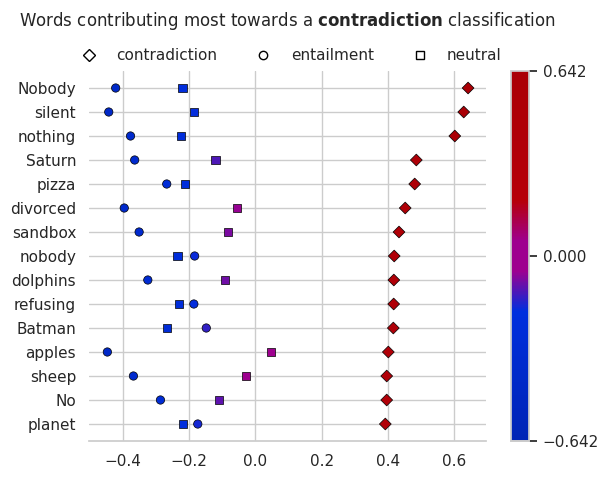

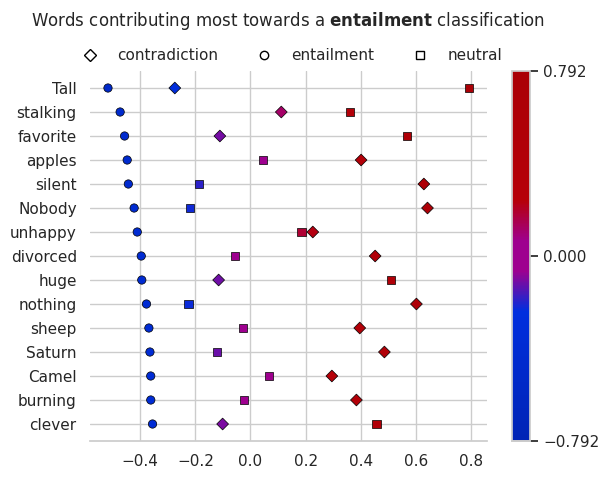

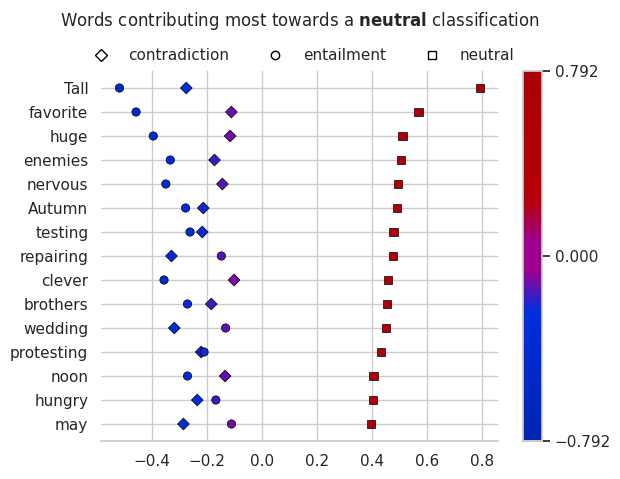

In [46]:
def sort_shap_dict_contribution(shap_dict, label_idx, return_only_one_label=True):
    shap_dict = dict(sorted(shap_dict.items(), key=lambda x: abs(x[1][label_idx]), reverse=True))
    if return_only_one_label:
        return {tok_feature: shap_val[label_idx] for tok_feature, shap_val in shap_dict.items()}
    else:
        return shap_dict

def make_custom_legend():
    handles, labels = plt.gca().get_legend_handles_labels()
    handles = [Line2D([0], [0], label=label, marker=LABEL_STR_MARKER[label], linestyle="", markerfacecolor=(0,0,0,0), markeredgecolor=(0,0,0,1)) for label in labels]
    plt.legend(handles=handles, labels=labels, frameon=False, ncols=3, bbox_to_anchor=(0.5, 1.1), loc="upper center")
    
def total_contribution_plot(shap_dict, label_idx_sort, return_only_one_label=False, filename=""):
    display_limit = 15
    sns.set_theme(style="whitegrid")
    shap_dict_aux = sort_shap_dict_contribution(shap_dict, label_idx_sort, return_only_one_label=return_only_one_label)
    x_vals = np.asarray(list(shap_dict_aux.values()))[:display_limit][::-1]
    y_vals = list(shap_dict_aux.keys())[:display_limit][::-1]
    vmin, vmax = np.min(x_vals), np.max(x_vals)
    vmin, vmax = -vmax, vmax
    vmean = np.mean([vmin, vmax])
    if not return_only_one_label:
        for label_idx in range(3):
            plt.scatter(x=x_vals[:,label_idx], y=y_vals, vmin=vmin, vmax=vmax, c=x_vals[:,label_idx], cmap=custom_cmap, marker=LABEL_STR_MARKER[LABEL_MAP[label_idx]], label=LABEL_MAP[label_idx], edgecolor="black", linewidth=0.5)
        make_custom_legend()
    else:
        plt.scatter(x=x_vals, y=y_vals, vmin=vmin, vmax=vmax, c=x_vals, cmap=custom_cmap, marker=LABEL_STR_MARKER[LABEL_MAP[label_idx_sort]])

    plt.colorbar(ticks=[vmin, vmean, vmax])
    sns.despine(left=True)
    plt.title(f"Words contributing most towards a $\\bf{{{LABEL_MAP[label_idx_sort]}}}$ classification", y=1.1)
    plt.savefig(filename + "_" + LABEL_MAP[label_idx_sort] + "_" + ".png")
    plt.show()

filename = link.split("/")[-1] + "_" + data_name
for idx_label in range(3):
    total_contribution_plot(shap_dict, idx_label, return_only_one_label=False, filename=filename)